# TMAlign all GB1 variant structures

In [1]:
import pandas as pd
import numpy as np
import random
import umap
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

In [2]:
# Ignore UserWarning from UMAP
warnings.simplefilter(action='ignore', category=UserWarning)

# set states for numpy and random
np.random.seed(42)
random.seed(42)

Load all sequences in GB1 variant library - includes all model desiged sequences, calibration sequences, and 3 wt controls.

In [3]:
# ALL LIBRARY SEQUENCES - load all sequences designed by models
lib_seqs = pd.read_csv('designs.csv')
lib_seqs.rename(columns={'seq_id':'seq_ID'}, inplace=True)
lib_seqs.set_index('seq_ID', inplace=True, drop=False)
lib_seqs.index.name = 'seq_ID'
lib_seqs = lib_seqs[['seq_ID', 'seq', 'fit', 'model', 'num_mut']].copy()

# add models for calibration and wt seqs
for index, row in lib_seqs[lib_seqs.model.isna()].iterrows():
    lib_seqs.loc[index, 'model'] = row.seq_ID.split('_')[0]

# some sequeneces were designed by multiple models (ex. seq_2) - expand those rows
# so that each seq is designated as a single model per row
exlib_seqs = []
for index, row in lib_seqs.iterrows():
    for m in row.model.split(','):
        new_row = row.copy()
        new_row.model = m
        exlib_seqs.append(new_row)
exlib_seqs = pd.DataFrame.from_dict(exlib_seqs)

Load sequences with functional scores from FACS experiments. Includes most sequences in library. Use this data to label library sequences with functional state.

In [4]:
# FUNCTIONAL DATA FROM FACS SCREENS - not all library designs are present in this file
# load scored designs - file output at end of 03_design_experimental_analysis.ipynb
counts_df = pd.read_csv('designs_scores.csv', index_col=0)

# get columns with 'Unnamed' in them
unnamed_cols = counts_df.columns[counts_df.columns.str.contains('Unnamed')]
counts_df.drop(columns=unnamed_cols, inplace=True)
counts_df.rename(columns={'seq_id':'seq_ID'}, inplace=True)
counts_df.set_index('seq_ID', inplace=True, drop=False)
counts_df.index.name = 'seq_ID'

# keep useful data
counts_df = counts_df[['seq_ID', 'seq', 'fit', 'model', 'num_mut', 'ebind', 'edisp', 'bin']].copy()

# add models for calibration and wt seqs
for index, row in counts_df[counts_df.model.isna()].iterrows():
    counts_df.loc[index, 'model'] = row.seq_ID.split('_')[0]


# categorize designs with experimental data
ebind = -0.5  # bind cutoff
edisplay = -.26  # display cutoff

counts_df.loc[counts_df[counts_df.ebind >= ebind].index, 'bind_v_display'] =  'B'
counts_df.loc[counts_df[counts_df.edisp >= edisplay].index, 'bind_v_display'] =  'D'
counts_df.loc[counts_df[(counts_df.edisp >= edisplay) & (counts_df.ebind >= ebind)].index, 'bind_v_display'] =  'B+D'
counts_df.bind_v_display.fillna('I', inplace=True)

# add these labels to library sequences
# 50 library sequences do not have functional scores
exlib_seqs['bind_v_display'] = counts_df.bind_v_display

In [5]:
# load tmscores as a distance matrix (substract tmscore from 1)
tm_scores = 1 - pd.read_csv('data/04_pairwise_tmscores.csv', index_col=0)

# only plot designed sequences
designs = [idx for idx, row in tm_scores.iterrows() if idx.startswith('seq')]
lib_tmscores = tm_scores.loc[designs, designs]


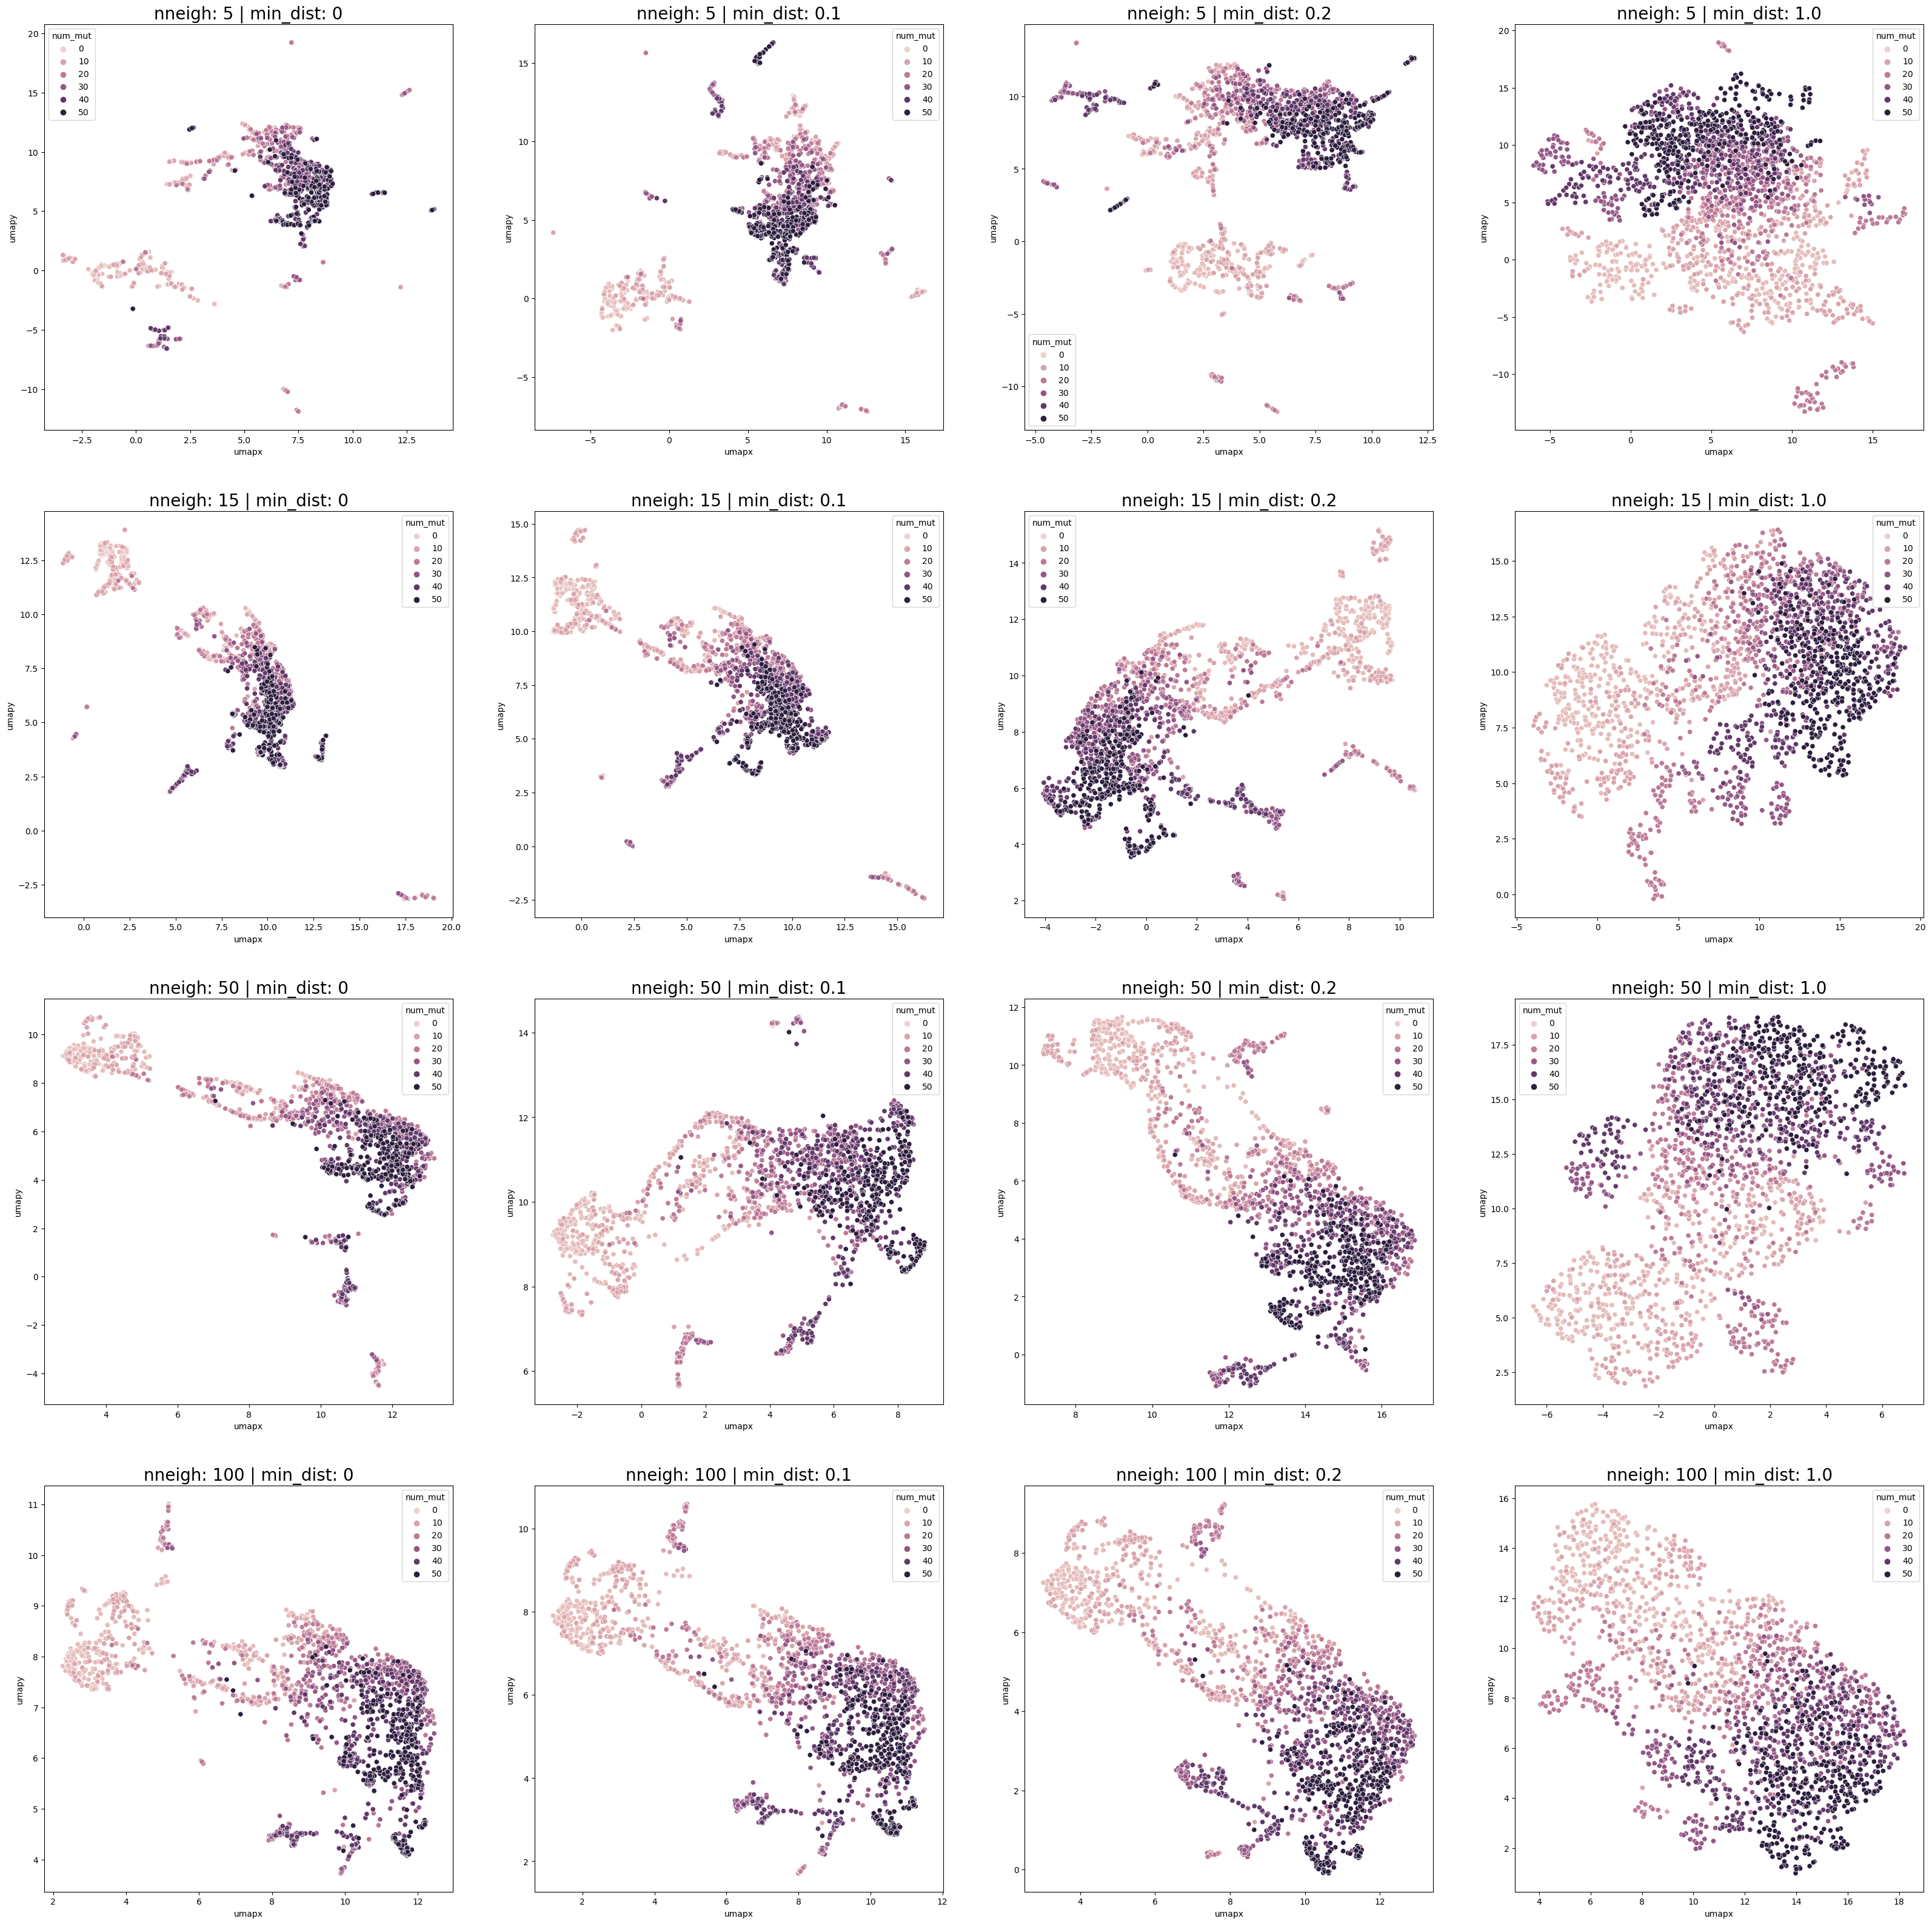

In [6]:
n_neigh_list = [5,15,50,100]
# n_neigh_list = [5]
min_dist_list = [ 0, 0.1, 0.2, 1.0]
# min_dist_list = [0.2, 1.0]

fig, axs = plt.subplots(len(n_neigh_list), len(min_dist_list), figsize=(40,40))

for (nneigh, min_dist), ax in zip(product(n_neigh_list, min_dist_list), axs.flatten()):

    # np.random.seed(1)

    reducer = umap.UMAP(metric='precomputed',
                        min_dist=min_dist,
                        n_neighbors=nneigh,
                        random_state=1,
                        # n_jobs=1,
                        init='random')
    embedding = reducer.fit_transform(lib_tmscores.to_numpy())
    
    exlib_seqs['umapx'] = pd.Series(embedding[:,0], index=lib_tmscores.index)
    exlib_seqs['umapy'] = pd.Series(embedding[:,1], index=lib_tmscores.index)

    sns.scatterplot(data=exlib_seqs, x='umapx', y='umapy', hue='num_mut', ax=ax)
    ax.set_title(f'nneigh: {nneigh} | min_dist: {min_dist}', fontsize=20)

# plt.savefig('tmalign_umap_nmuts.png', dpi=300)

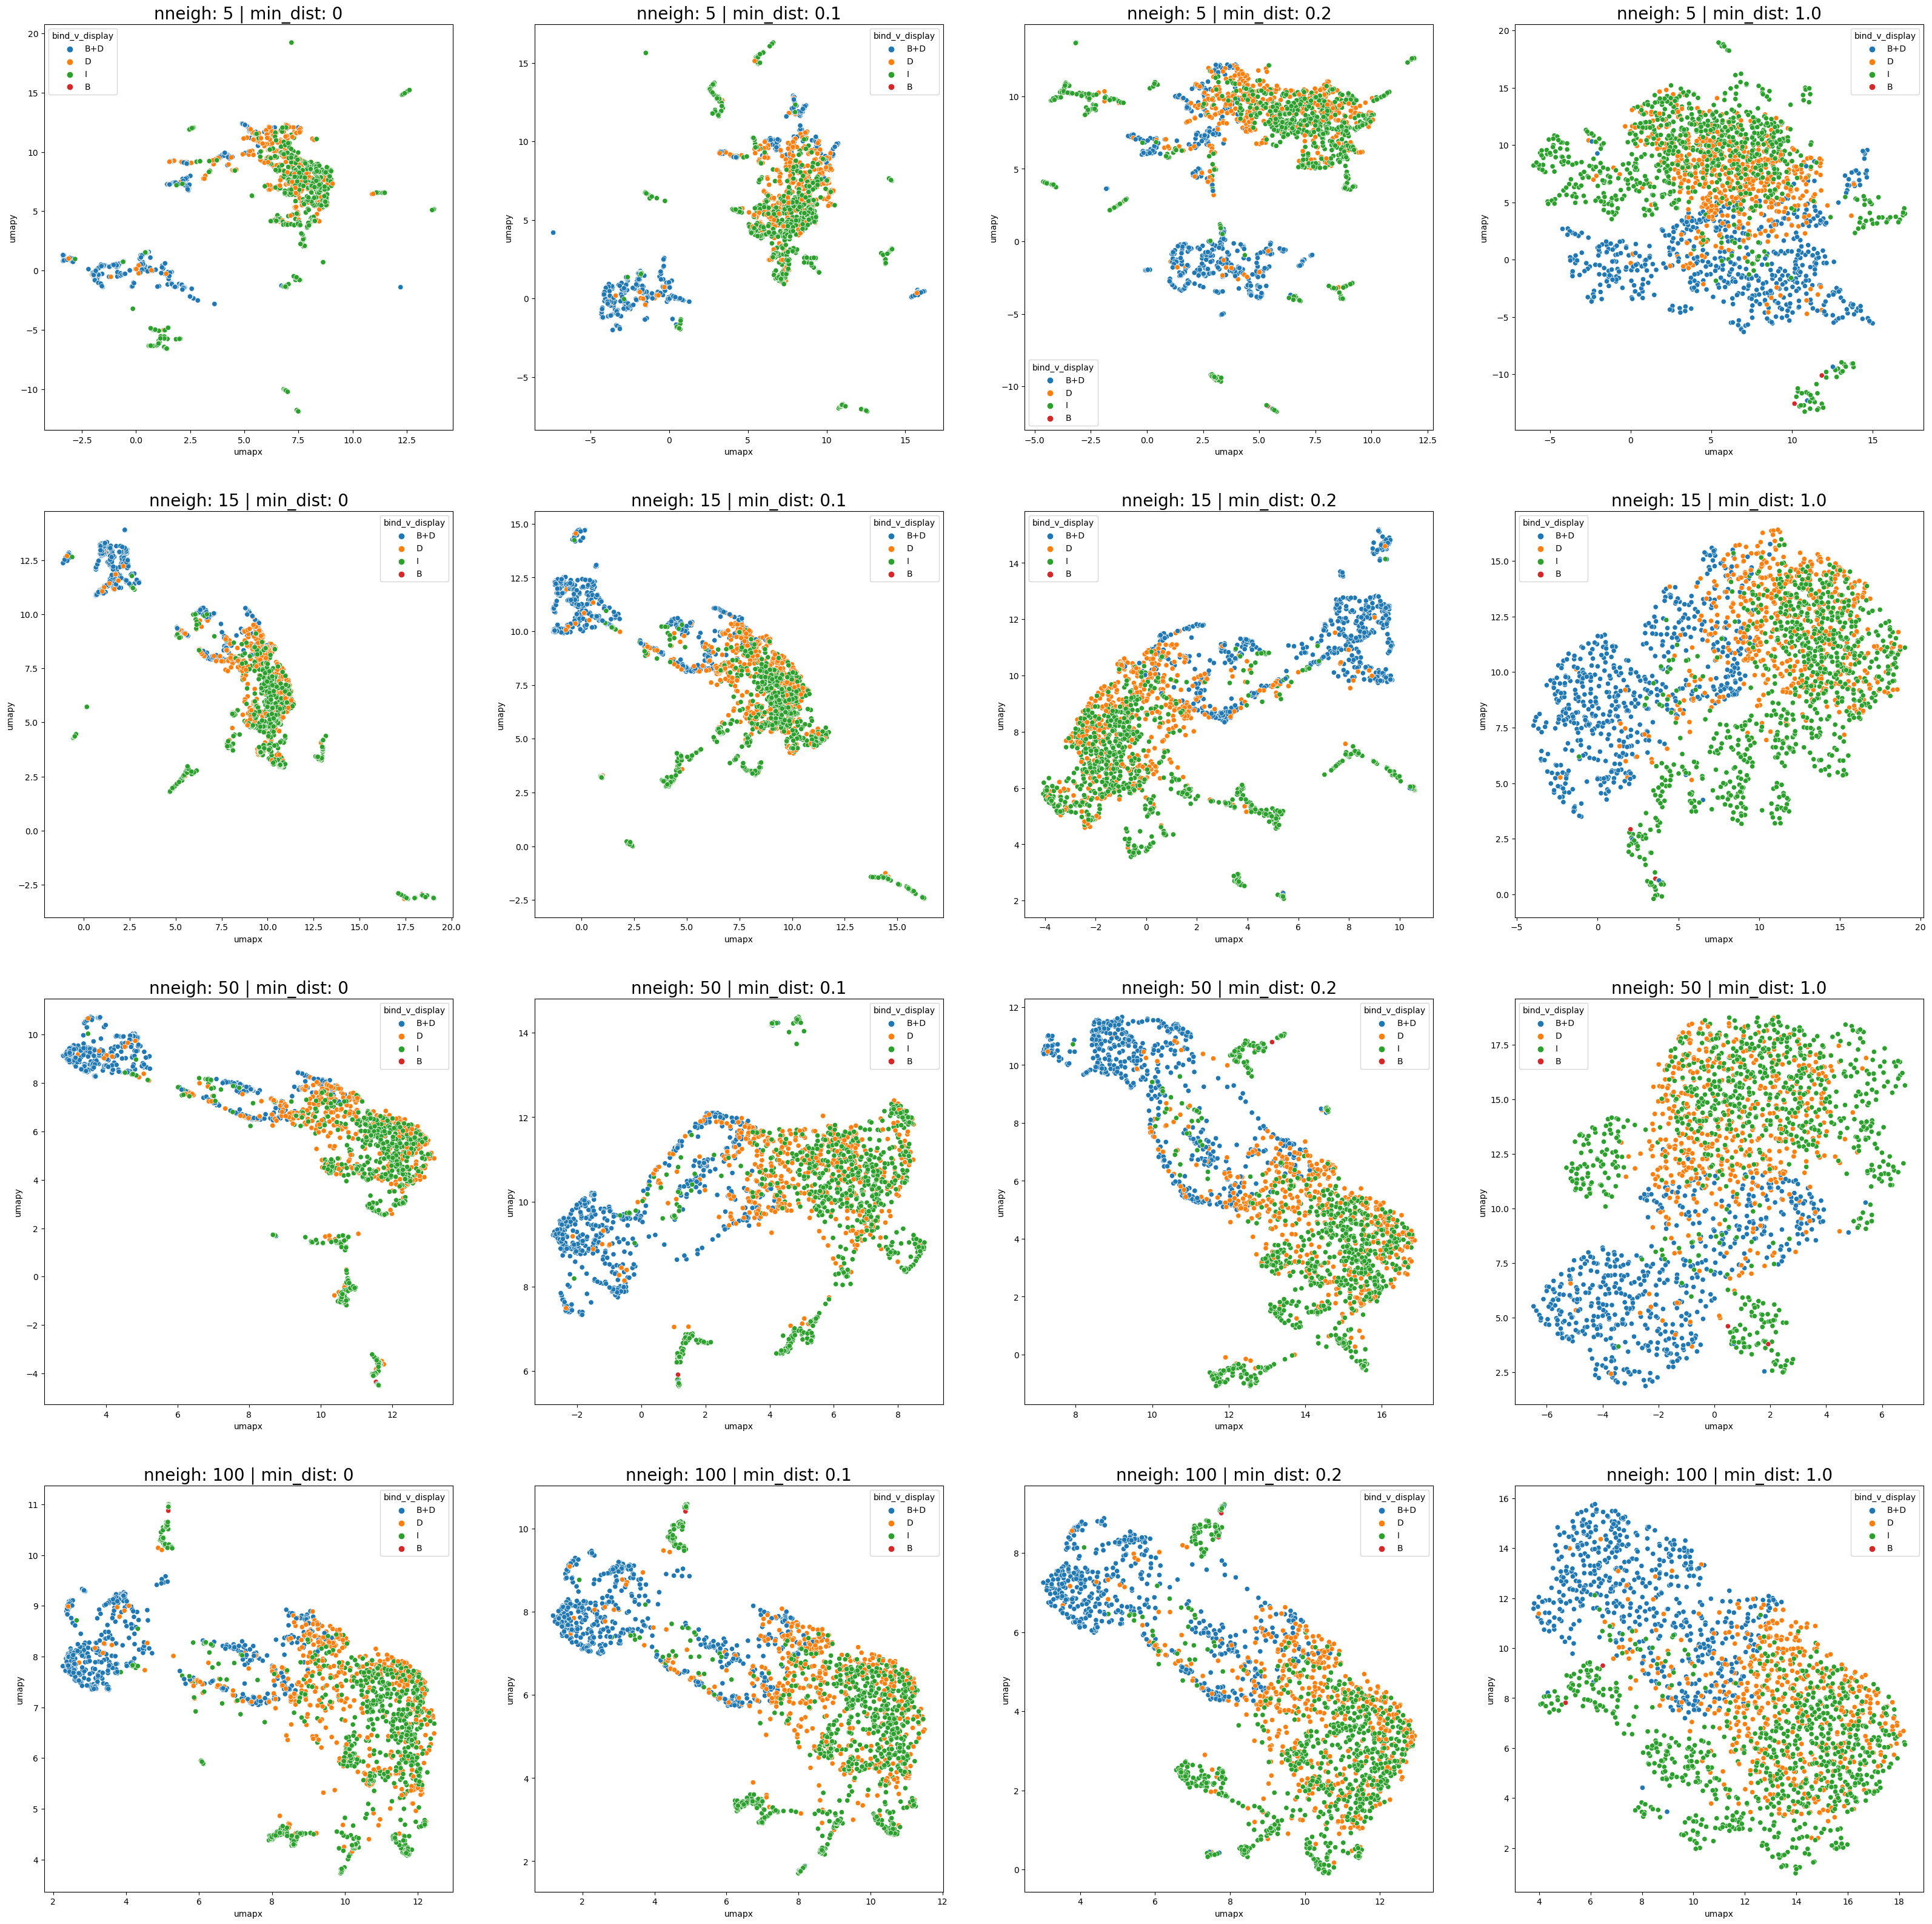

In [7]:
n_neigh_list = [5,15,50,100]
# n_neigh_list = [5]
min_dist_list = [ 0, 0.1, 0.2, 1.0]
# min_dist_list = [0.2, 1.0]

fig, axs = plt.subplots(len(n_neigh_list), len(min_dist_list), figsize=(40,40))

for (nneigh, min_dist), ax in zip(product(n_neigh_list, min_dist_list), axs.flatten()):
    reducer = umap.UMAP(metric='precomputed',
                        min_dist=min_dist,
                        n_neighbors=nneigh,
                        random_state=1,
                        n_jobs=1,
                        init='random')
    embedding = reducer.fit_transform(lib_tmscores.to_numpy())
    
    exlib_seqs['umapx'] = pd.Series(embedding[:,0], index=lib_tmscores.index)
    exlib_seqs['umapy'] = pd.Series(embedding[:,1], index=lib_tmscores.index)

    sns.scatterplot(data=exlib_seqs, x='umapx', y='umapy', hue='bind_v_display', ax=ax)
    ax.set_title(f'nneigh: {nneigh} | min_dist: {min_dist}', fontsize=20)

# plt.savefig('tmalign_umap_nmuts.png', dpi=300)

Paper figure with `n_neighbors=50` and `min_dist=0.1`.

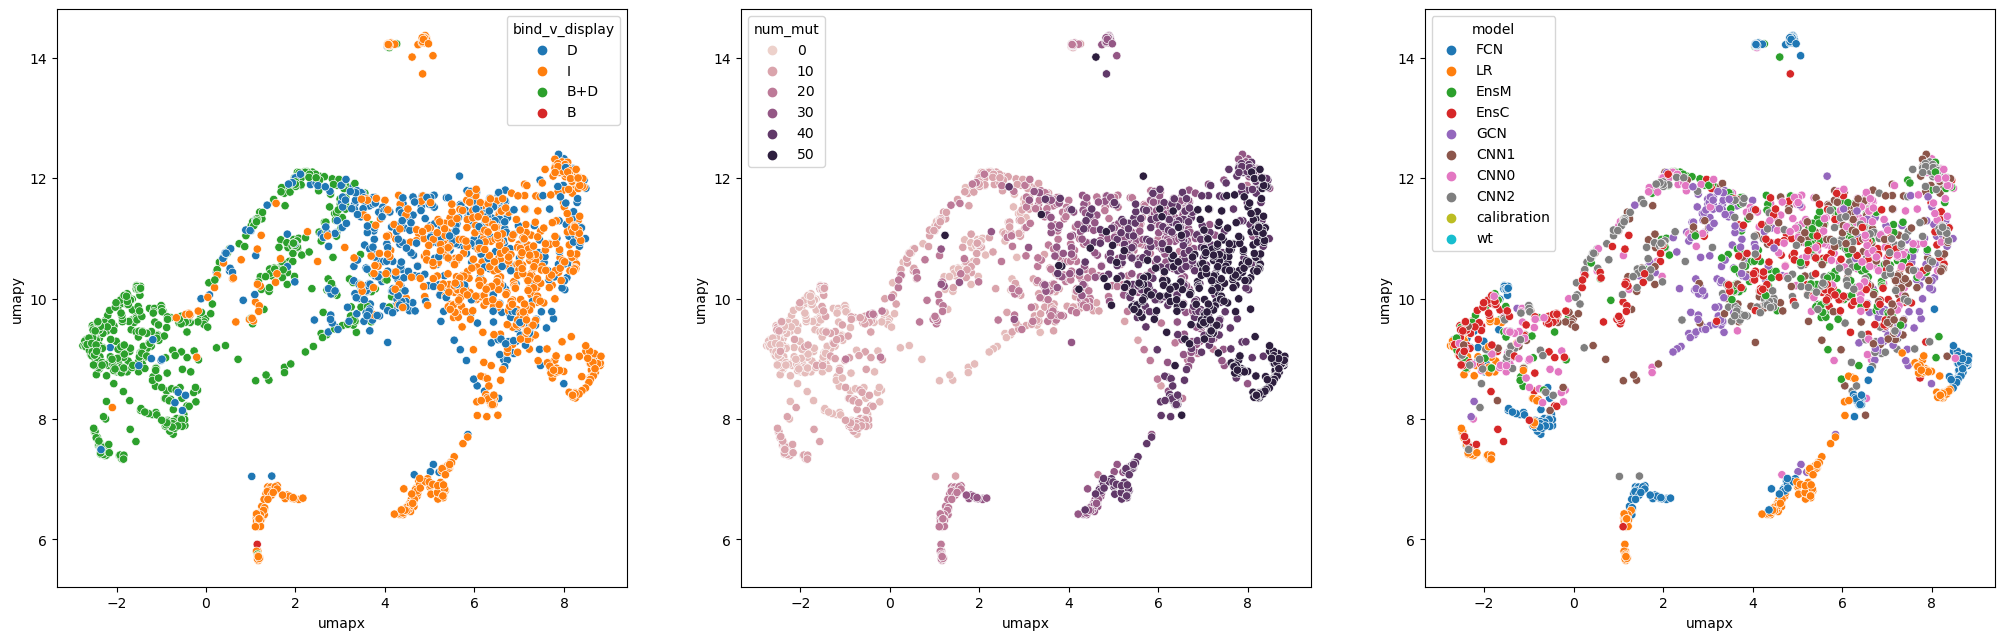

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(25,7.5), gridspec_kw={'height_ratios': [1]})

reducer = umap.UMAP(metric='precomputed', min_dist=0.1, n_neighbors=50, random_state=1, init='random')
embedding = reducer.fit_transform(lib_tmscores)

exlib_seqs['umapx'] = pd.Series(embedding[:,0], index=lib_tmscores.index)
exlib_seqs['umapy'] = pd.Series(embedding[:,1], index=lib_tmscores.index)

sns.scatterplot(data=exlib_seqs, x='umapx', y='umapy', hue='bind_v_display', ax=axs[0], hue_order=['D','I', 'B+D', 'B'])
sns.scatterplot(data=exlib_seqs, x='umapx', y='umapy', hue='num_mut', ax=axs[1])
sns.scatterplot(data=exlib_seqs, x='umapx', y='umapy', hue='model', ax=axs[2])

# plt.savefig('tmalign_umap_function.svg')
plt.show()

Save source data for figure 4b.

In [9]:
src_data = exlib_seqs.dropna(subset='umapx')
src_data = src_data[['seq_ID', 'bind_v_display', 'num_mut', 'model', 'umapx', 'umapy']].copy()
src_data.to_csv('source_data_files/fig_4b_src.csv')